# Computing saliency masks on mazes with PAIR-Saliency

This notebook demonstrates a number of saliency mask techniques, augmented with the `SmoothGrad` technique, using the Inception V3 convolutional neural network. The intention of this notebook is to have as few dependencies as possible to show how to compute masks.

This notebook shows the following techniques, alongside with the `SmoothGrad` augmentation:

*   Vanilla Gradients
    ([paper](https://scholar.google.com/scholar?q=Visualizing+higher-layer+features+of+a+deep+network&btnG=&hl=en&as_sdt=0%2C22),
    [paper](https://arxiv.org/abs/1312.6034))
*   Guided Backpropogation ([paper](https://arxiv.org/abs/1412.6806))
*   Integrated Gradients ([paper](https://arxiv.org/abs/1703.01365))
*   Occlusion


In [1]:
# Boilerplate imports.
import tensorflow as tf
import numpy as np
import PIL.Image
from PIL import ImageDraw
from matplotlib import pylab as P
import pickle
import random
import os
slim=tf.contrib.slim

if not os.path.exists('models/research/slim'):
  !git clone https://github.com/tensorflow/models/
old_cwd = os.getcwd()
os.chdir('models/research/slim')
from nets import inception_v3
os.chdir(old_cwd)

# From our repository.
import saliency

%matplotlib inline

Instructions for updating:
Use the retry module or similar alternatives.


### Utility methods

In [2]:
# Boilerplate methods.
def ShowImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    im = ((im + 1) * 127.5).astype(np.uint8)
    P.imshow(im)
    P.title(title)

def resize(img, size):
    im = img.resize((size, size))
    im = np.asarray(im)[:, :, :3]
    return im / 127.5 - 1.0

def drawPath(img, list_of_points, color, visuals=True):
    '''mark original maze with path or with salient points'''
    maze_original_edited = np.copy(img)
    for i, point in enumerate(list_of_points):
        x,y = point
        maze_original_edited[x,y] = color 
    if visuals:
        ShowImage(maze_original_edited)
    return maze_original_edited

### Maze generator code
Run the following cell to generate a new bmp of a new cell 32x32 in size.

In [3]:
def update_pos(direct, x, y):
    if direct == 0:
        return (x+1,y)
    elif direct == 1:
        return (x, y+1)
    elif direct == 2:
        return (x-1, y)
    else:
        return (x, y - 1)


def carve(maze, x, y, height, width):
    direction = random.randint(0,4)
    count = 0
    while count < 4:
        (x1, y1) = update_pos(direction, x, y)
        (x2, y2) = update_pos(direction, x1, y1)
        if x2 > 0 and x2 < width and y2 > 0 and y2 < height:
            if maze[y1,x1] == 1 and maze[y2,x2] == 1:
                maze[y1, x1] = 0
                maze[y2, x2] = 0
                carve(maze, x2, y2, height, width)
        count = count + 1
        direction = (direction + 1) % 4

def writeImage(a, entry = True):
    out = PIL.Image.new('RGB', a.shape, (255,255,255))
    d = ImageDraw.Draw(out)

    (height, width) = a.shape
    for x in range(height):
        for y in range(width):
            if a[y,x] == 0:
                d.point([x,y], fill=(255,255,255))
            else:
                d.point([x,y], fill=(0,0,0))
    if entry:
        d.point([1,0], fill=(255,0,0))
        d.point([width - 2, height - 1], fill=(255,0,0))

    return out

def generate(width, height):
    if width < 2 or height < 2:
        raise "Maze needs to be at least 2x2"
    maze = np.ones((height,width))
    maze[1, 1] = 0
    carve(maze, 1,1, height, width)
    maze[0,1] = 0 
    maze[height - 1, width - 2] = 0
    return maze

### Loading the Inception model graph

Run the following cell to download the network. Alternatively, the pretrained network can be downloaded [here](https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip). Unpack the tensorflow_inception_graph.pb file from the archive and set its path to model_fn variable.

In [4]:
# Use either wget or curl depending on your OS.
if not os.path.exists('inception_v3.ckpt'):
  #!wget http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
  !curl -O http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
  !tar -xvzf inception_v3_2016_08_28.tar.gz

ckpt_file = './inception_v3.ckpt'

### Adding a single logit tensor for which we want to compute the mask

In [5]:
graph = tf.Graph()

with graph.as_default():
    images = tf.placeholder(tf.float32, shape=(None, 320, 320, 3))

    with slim.arg_scope(inception_v3.inception_v3_arg_scope()):
        _, end_points = inception_v3.inception_v3(images, is_training=False, num_classes=1001)
    
        # Restore the checkpoint
        sess = tf.Session(graph=graph)
        saver = tf.train.Saver()
        saver.restore(sess, ckpt_file)
    
    # Construct the scalar neuron tensor.
    logits = graph.get_tensor_by_name('InceptionV3/Logits/SpatialSqueeze:0')
    neuron_selector = tf.placeholder(tf.int32)
    y = logits[0][neuron_selector]
    
    # Construct tensor for predictions.
    prediction = tf.argmax(logits, 1)


INFO:tensorflow:Restoring parameters from ./inception_v3.ckpt


Prediction class for maze: 647


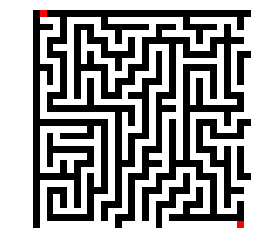

In [7]:
# Load the image
mazeimg = resize(writeImage(generate(32,32)), 320)

# Show the image
ShowImage(mazeimg)

# Get Inception v3 prediction class
prediction_class = sess.run(prediction, feed_dict = {images: [mazeimg]})[0]
print("Prediction class for maze:", prediction_class)

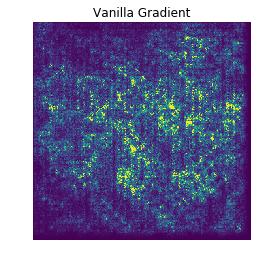

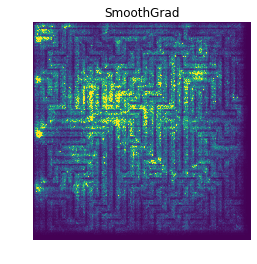

In [8]:
def smoothgrad(img, pred_class):
    # Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
    gradient_saliency = saliency.GradientSaliency(graph, sess, y, images)
    
    # Compute the vanilla mask and the smoothed mask.
    vanilla_mask_3d = gradient_saliency.GetMask(img, feed_dict = {neuron_selector: pred_class})
    smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(img, feed_dict = {neuron_selector: pred_class})

    # Call the visualization methods to convert the 3D tensors to 2D grayscale.
    vanilla_mask = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
    smoothgrad_mask = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)
    return (vanilla_mask, smoothgrad_mask)

# call smoothgrad
(vanilla_mask_grayscale, smoothgrad_mask_grayscale) = smoothgrad(mazeimg, prediction_class)

# Render the saliency masks.
ShowImage(vanilla_mask_grayscale, title='Vanilla Gradient')
ShowImage(smoothgrad_mask_grayscale, title='SmoothGrad')

### Vanilla Gradient & SmoothGrad

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt


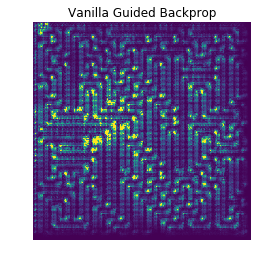

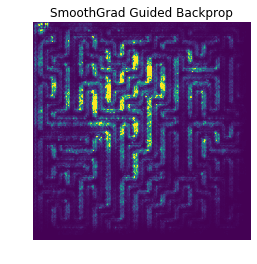

In [9]:
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
# NOTE: GuidedBackprop creates a copy of the given graph to override the gradient.
# Don't construct too many of these!

def smoothgrad_backprop(img, pred_class):
    guided_backprop = saliency.GuidedBackprop(graph, sess, y, images)

    # Compute the vanilla mask and the smoothed mask.
    vanilla_guided_backprop_mask_3d = guided_backprop.GetMask(
        img, feed_dict = {neuron_selector: pred_class})
    smoothgrad_guided_backprop_mask_3d = guided_backprop.GetSmoothedMask(
        img, feed_dict = {neuron_selector: pred_class})

    # Call the visualization methods to convert the 3D tensors to 2D grayscale.
    vanilla_mask = saliency.VisualizeImageGrayscale(vanilla_guided_backprop_mask_3d)
    smoothgrad_mask = saliency.VisualizeImageGrayscale(smoothgrad_guided_backprop_mask_3d)
    return (vanilla_mask, smoothgrad_mask)


# call smoothgrad_backprop
(vanilla_mask_grayscale, smoothgrad_mask_grayscale) = smoothgrad_backprop(mazeimg, prediction_class)

# Render the saliency masks.
ShowImage(vanilla_mask_grayscale, title='Vanilla Guided Backprop')
ShowImage(smoothgrad_mask_grayscale, title='SmoothGrad Guided Backprop')

## Integrated Gradients & SmoothGrad

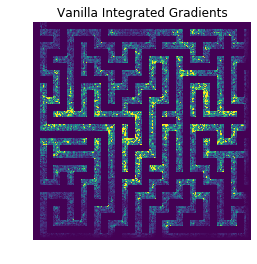

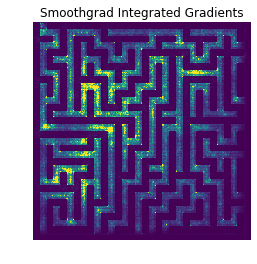

In [10]:
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
def smoothgrad_integr(img, pred_class):
    integrated_gradients = saliency.IntegratedGradients(graph, sess, y, images)

    # Baseline is a black image.
    baseline = np.zeros(img.shape)
    baseline.fill(-1)

    # Compute the vanilla mask and the smoothed mask.
    vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
      img, feed_dict = {neuron_selector: pred_class}, x_steps=25, x_baseline=baseline)
    # Smoothed mask for integrated gradients will take a while since we are doing nsamples * nsamples computations.
    smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(
      img, feed_dict = {neuron_selector: pred_class}, x_steps=25, x_baseline=baseline)

    # Call the visualization methods to convert the 3D tensors to 2D grayscale.
    vanilla_mask = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
    smoothgrad_mask = saliency.VisualizeImageGrayscale(smoothgrad_integrated_gradients_mask_3d)
    return (vanilla_mask, smoothgrad_mask)


# call smoothgrad_integr
(vanilla_mask_grayscale, smoothgrad_mask_grayscale) = smoothgrad_integr(mazeimg, prediction_class)

# Render the saliency masks.
ShowImage(vanilla_mask_grayscale, title='Vanilla Integrated Gradients')
ShowImage(smoothgrad_mask_grayscale, title='Smoothgrad Integrated Gradients')

# Find most salient point in original maze 

In [11]:
import numpy as np
import heapq

def perturbate(maze, point):
    (x,y) = point
    (height, width) = maze.shape
    if (maze[x,y] == 1 and x < height - 1 and maze[x+1,y] == 0):
        return (x+1,y)
    if (maze[x,y] == 1 and x > 0 and maze[x-1,y] == 0):
        return (x-1,y)
    if (maze[x,y] == 1 and y < width - 1 and maze[x,y+1] == 0):
        return (x,y+1)
    if (maze[x,y] == 1 and y > 0 and maze[x,y-1] == 0):
        return (x,y-1)
    return (x,y)

def getKpoints(salientbig, salientsmall, k):
    ratiox = int(salientbig.shape[0]/salientsmall.shape[0])
    ratioy = int(salientbig.shape[1]/salientsmall.shape[1])
    larger = []

    for x in range(len(salientsmall)-1):
        for y in range(len(salientsmall)-1):
            candid = np.sum(salientbig[ratiox * x:ratiox*(x+1), ratioy*y:ratioy*(y+1)])
            heapq.heappush(larger, (candid, (x,y)))
    
    return [perturbate(salientsmall, x[1]) for x in heapq.nlargest(k, larger)]   

# Get K random points (control)
def getKrandom(salientsmall, k):
    randtups = [(random.randint(0, salientsmall.shape[0]-1), random.randint(0, salientsmall.shape[1]-1)) for i in range(k)]
    return [perturbate(salientsmall, t) for t in randtups]

# salient_points_original = getKpoints(smoothgrad_mask_grayscale, maze, 3)
# maze_with_saliency = drawPath(resize(out, 32), salient_points_original, [-1,0,-1])
# print("{} most salient points in actual maze: ".format(salient_points_original))

# Maze Solver

In [12]:
import itertools
from scipy import misc
from scipy.sparse.dok import dok_matrix
from scipy.sparse.csgraph import dijkstra

# Defines a translation from 2 coordinates to a single number
def to_index(img, y, x):
    return y * img.shape[1] + x


# Defines a reversed translation from index to 2 coordinates
def to_coordinates(img, index):
    return int(index / img.shape[1]), int(index % img.shape[1])

def get_pred(img, preds, source, target, path):
    if target == source:
        return path
    parent = preds[0][target]
    return get_pred(img, preds, source, parent, path + [to_coordinates(img, parent)])

def solve(img):
    # A sparse adjacency matrix.
    # Two pixels are adjacent in the graph if both are painted.
    adjacency = dok_matrix((img.shape[0] * img.shape[1],
                            img.shape[0] * img.shape[1]), dtype=bool)

    # The following lines fills the adjacency matrix by
    directions = [(1,0), (0,1), (-1, 0), (0,-1)]
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i, j] != 0:
                continue

            for y_diff, x_diff in directions:
                if i + y_diff < img.shape[0] and j + x_diff < img.shape[1] and i + y_diff > 0 and j + x_diff > 0 and img[i + y_diff, j + x_diff] == 0:
                    adjacency[to_index(img, i, j),
                              to_index(img, i + y_diff, j + x_diff)] = True

    # We chose two arbitrary points, which we know are connected
    source = to_index(img, 0, 1)
    target = to_index(img, img.shape[0] - 1, img.shape[1] - 2)

    # Compute the shortest path between the source and all other points in the image
    _, preds = dijkstra(adjacency, directed=False, indices=[source],
                           unweighted=True, return_predecessors=True)

    return get_pred(img, preds, source, target, [])

### Altogether now
Run everything together and see how salience does in predicting solutions.

In [13]:
def check_sol(sol, salient_pts):
    truthtable = []
    for pt in salient_pts:
        if pt in sol:
            truthtable.append(True)
        else:
            truthtable.append(False)
    return truthtable

def salience(maze, visuals=False):
    mazeimg = resize(writeImage(maze), 320)
    
    # Run Inception v3 for image classification
    prediction_class = sess.run(prediction, feed_dict = {images: [mazeimg]})[0]

    (smooth_a, smooth_b) = smoothgrad(mazeimg, prediction_class)
    (backprop_a, backprop_b) = smoothgrad_backprop(mazeimg, prediction_class)
    (integr_a, integr_b) = smoothgrad_integr(mazeimg, prediction_class)

    if visuals:
        # Set up matplot lib figures.
        ROWS = 3
        COLS = 2
        UPSCALE_FACTOR = 10
        P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

        # Render the saliency masks.
        ShowImage(smooth_a, title='Vanilla Gradient', ax=P.subplot(ROWS, COLS, 1))
        ShowImage(smooth_b, title='Smoothgrad Gradient', ax=P.subplot(ROWS, COLS, 2))
        ShowImage(backprop_a, title='Vanilla Backprop', ax=P.subplot(ROWS, COLS, 3))   
        ShowImage(backprop_b, title='Smoothgrad Backprop', ax=P.subplot(ROWS, COLS, 4))
        ShowImage(integr_a, title='Vanilla Integrated Gradient', ax=P.subplot(ROWS, COLS, 5))   
        ShowImage(integr_b, title='Smoothgrad Integrated Gradient', ax=P.subplot(ROWS, COLS, 6)) 

    return { 'vanilla': getKpoints(smooth_a, maze, k),
             'smoothgrad': getKpoints(smooth_b, maze, k),
             'vanilla_backprop': getKpoints(backprop_a, maze, k),
             'smoothgrad_backprop': getKpoints(backprop_b, maze, k),
             'vanilla_integr': getKpoints(integr_a, maze, k),
             'smoothgrad_integr': getKpoints(integr_b, maze, k),
             'random' : getKrandom(maze, k) }   

In [ ]:
from tqdm import tqdm
import json

k = 1
STEPS = 100
good = { 'vanilla': [],
         'smoothgrad': [],
         'vanilla_backprop': [],
         'smoothgrad_backprop': [],
         'vanilla_integr': [],
         'smoothgrad_integr': [],
         'random' : [] }

for iteration in tqdm(range(STEPS)):
    # Generate new maze
    maze = generate(32, 32)
    # Get salience points
    salient = salience(maze, visuals = False)
    # Solve
    solution = solve(maze)
    
    # Compare solutions
    mazeout = drawPath(resize(writeImage(maze),32), solution, [211,211,211], visuals=False)
    mazeout = drawPath(mazeout, salient["vanilla"], [-1,0,-1], visuals=False)
    mazeout = drawPath(mazeout, salient["smoothgrad"], [-.8,0,-.8], visuals=False)
    mazeout = drawPath(mazeout, salient["vanilla_backprop"], [-.6,0,-.6], visuals=False)
    mazeout = drawPath(mazeout, salient["smoothgrad_backprop"], [-.4,0,-.4], visuals=False)
    mazeout = drawPath(mazeout, salient["vanilla_integr"], [.4,0,.4], visuals=False)
    mazeout = drawPath(mazeout, salient["smoothgrad_integr"], [.6,0,.6], visuals=False)
    mazeout = drawPath(mazeout, salient["random"], [.8,.2,.8], visuals=False) 
    
    good["vanilla"] += check_sol(solution, salient["vanilla"])
    good["smoothgrad"] += check_sol(solution, salient["smoothgrad"])
    good["vanilla_backprop"] += check_sol(solution, salient["vanilla_backprop"])
    good["smoothgrad_backprop"] += check_sol(solution, salient["smoothgrad_backprop"])
    good["vanilla_integr"] += check_sol(solution, salient["vanilla_integr"])
    good["smoothgrad_integr"] += check_sol(solution, salient["smoothgrad_integr"])
    good["random"] += check_sol(solution, salient["random"])

sol = {key : (sum(l)/(STEPS*k)) for (key, l) in good.items()}

# Log results
print(sol)
file = open("results100_k{{}}.txt".format(k),"w")
file.write(json.dumps(sol, sort_keys=True, indent=4, separators=(',', ': ')))
file.close()


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt



  1%|▊                                                                             | 1/100 [07:14<11:56:10, 434.05s/it]

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt



  2%|█▌                                                                            | 2/100 [14:16<11:43:19, 430.61s/it]

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt



  3%|██▎                                                                           | 3/100 [21:29<11:37:10, 431.24s/it]

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt



  4%|███                                                                           | 4/100 [28:57<11:37:55, 436.20s/it]

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt



  5%|███▉                                                                          | 5/100 [36:14<11:31:17, 436.61s/it]

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt



  6%|████▋                                                                         | 6/100 [43:33<11:24:52, 437.15s/it]

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt



  7%|█████▍                                                                        | 7/100 [51:23<11:33:08, 447.19s/it]

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt



  8%|██████▏                                                                       | 8/100 [59:20<11:39:23, 456.13s/it]

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt



  9%|██████▊                                                                     | 9/100 [1:07:36<11:49:43, 467.95s/it]

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt



 10%|███████▌                                                                   | 10/100 [1:16:29<12:11:30, 487.68s/it]

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt



 11%|████████▎                                                                  | 11/100 [1:25:27<12:25:29, 502.58s/it]

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt



 12%|█████████                                                                  | 12/100 [1:34:06<12:24:36, 507.69s/it]

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt



 13%|█████████▊                                                                 | 13/100 [1:42:35<12:16:41, 508.07s/it]

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt



 14%|██████████▌                                                                | 14/100 [1:51:29<12:19:04, 515.64s/it]

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt



 15%|███████████▎                                                               | 15/100 [2:00:07<12:11:27, 516.32s/it]

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt



 16%|████████████                                                               | 16/100 [2:09:10<12:14:17, 524.49s/it]

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt



 17%|████████████▊                                                              | 17/100 [2:18:37<12:23:10, 537.23s/it]

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt



 18%|█████████████▌                                                             | 18/100 [2:28:21<12:33:30, 551.35s/it]

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt



 19%|██████████████▎                                                            | 19/100 [2:38:08<12:38:29, 561.84s/it]

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt



 20%|███████████████                                                            | 20/100 [2:47:45<12:35:09, 566.37s/it]

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt



 21%|███████████████▊                                                           | 21/100 [2:57:35<12:35:02, 573.45s/it]

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt



 22%|████████████████▌                                                          | 22/100 [3:10:08<13:35:46, 627.52s/it]

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt



 23%|█████████████████▎                                                         | 23/100 [3:21:56<13:56:15, 651.63s/it]

In [ ]:
first = {"vanilla":[],"smoothgrad":[],"vanilla_backprop":[],"smoothgrad_backprop":[],"vanilla_integr":[],"smoothgrad_integr":[],"random":[]}
for dnn in good.keys():
    for i in range(0, len(good[dnn]), 3):
        first[dnn].append(good[dnn][i])

for dnn in first.keys():
    print(dnn,sum(first[dnn])/len(first[dnn]))

print()
second = {"vanilla":[],"smoothgrad":[],"vanilla_backprop":[],"smoothgrad_backprop":[],"vanilla_integr":[],"smoothgrad_integr":[],"random":[]}
for dnn in good.keys():
    for i in range(1, len(good[dnn]), 3):
        second[dnn].append(good[dnn][i])  
print()
for dnn in second.keys():
    print(dnn,sum(second[dnn])/len(second[dnn]))
    
    
third = {"vanilla":[],"smoothgrad":[],"vanilla_backprop":[],"smoothgrad_backprop":[],"vanilla_integr":[],"smoothgrad_integr":[],"random":[]}
for dnn in good.keys():
    for i in range(2, len(good[dnn]), 3):
        third[dnn].append(good[dnn][i])  
print()

for dnn in third.keys():
    print(dnn,sum(third[dnn])/len(third[dnn]))

In [ ]:
mazeout = drawPath(resize(writeImage(maze),32), solution, [211,211,211])
drawPath(mazeout, salient["vanilla_backprop"], [.6,0,.6])
